In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings(action='once')
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

1. Import excel file, this excel file contains the COVID-19 confirmed cases have been recorded daily from 27th April to 24th November 2021.

In [20]:
data = pd.read_excel('data.xlsx')
plot_rawdata = px.line(data,x='Date',y='Confirmed case',title='Recorded confirmed cases times series plot')
plot_rawdata.show()

/home/b/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [21]:
data

,Date,Confirmed case,Vaccination rate,Vaccination coverage,Social Distancing (m),Incubation period (days),Generation time (days)
0,2021-04-27,0,8047,112,2,3.41,2.76
1,2021-04-28,0,7996,111,2,6.02,3.89
2,2021-04-29,1,8043,112,2,7.04,2.51
3,2021-04-30,2,7520,104,2,2.28,0.40
4,2021-05-01,3,7055,98,2,1.16,4.82
...,...,...,...,...,...,...,...
206,2021-11-19,1339,19214,267,2,3.53,5.70
207,2021-11-20,1046,18328,255,1,4.85,4.66
208,2021-11-21,1265,9881,137,1,3.25,0.54
209,2021-11-22,1547,7754,108,1,3.31,1.91


2. The first step in model ARIMA development is considering whether the data is stationary. Hence, an ADF test is provided in the code. From which, d parameters will then be determined based on the stationarity of data in which differencing stage. The COVID-19 confirmed cases in this study is considered to be stationary on the first differencing, which means d = 1 in ARIMA model

In [22]:
# ADF Test
# Considering whether the raw data is stationary or not
confirmedcase_raw = data['Confirmed case'].values
raw_adf_test = adfuller(confirmedcase_raw)

print('The result of ADF test of raw data is:')

print('ADF Statistic: %f' % raw_adf_test[0])

print('p-value: %f' % raw_adf_test[1])

print('Critical values:')
for key,value in raw_adf_test[4].items():
    print(key,value)

if raw_adf_test[0] < raw_adf_test[4]['5%']:
    print('Reject H0 - Time Series is Stationary')
else:
    print('Failed to Reject H0 - Time Series is Non-Stationary')

The result of ADF test of raw data is:
ADF Statistic: -1.512470
p-value: 0.527334
Critical values:
1% -3.462980134086401
5% -2.875885461947131
10% -2.5744164898444515
Failed to Reject H0 - Time Series is Non-Stationary


In [23]:
# ADF Test
# Considering whether the 1st differencing data is stationary or not
data['1st Differencing'] = data['Confirmed case'] - data['Confirmed case'].shift(1)
data['1st Differencing'] = data['1st Differencing'].fillna(0)
data['1st Differencing'] = data['1st Differencing'].astype(int)

plot_1stdata = px.line(data,x='Date',y='1st Differencing',title='1st Differencing Data cases times series plot')
plot_1stdata.show()

confirmedcase_1st = data['1st Differencing'].values
first_adf_test = adfuller(confirmedcase_1st)

print('The result of ADF test of raw data is:')

print('ADF Statistic: %f' % first_adf_test[0])

print('p-value: %f' % first_adf_test[1])

print('Critical values:')
for key,value in first_adf_test[4].items():
    print(key,value)

if first_adf_test[0] < first_adf_test[4]['5%']:
    print('Reject H0 - Time Series is Stationary')
else:
    print('Failed to Reject H0 - Time Series is Non-Stationary')

/home/b/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



The result of ADF test of raw data is:
ADF Statistic: -5.318863
p-value: 0.000005
Critical values:
1% -3.462818103072159
5% -2.8758145932936805
10% -2.574378674548251
Reject H0 - Time Series is Stationary


In [24]:
data[['Date','Confirmed case','1st Differencing']]

,Date,Confirmed case,1st Differencing
0,2021-04-27,0,0
1,2021-04-28,0,0
2,2021-04-29,1,1
3,2021-04-30,2,1
4,2021-05-01,3,1
...,...,...,...
206,2021-11-19,1339,-270
207,2021-11-20,1046,-293
208,2021-11-21,1265,219
209,2021-11-22,1547,282


3. AR(p) and MA(q) were determined using ACF and PACF method

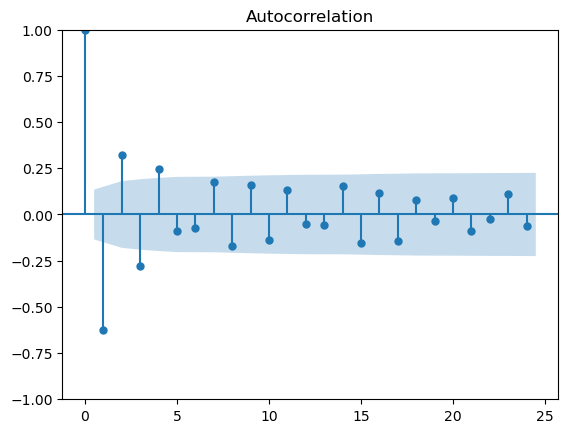

In [25]:
acf_plot = plot_acf(data['1st Differencing'].dropna())

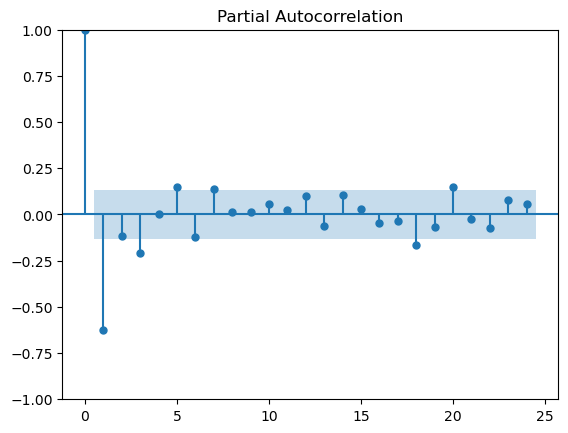

In [26]:
pacf_plot = plot_pacf(data['1st Differencing'].dropna(),method='ywm')

4. To implement the external parameters into the model, the study uses Pearson’s correlation to determine the relationships between Confirmed cases and external data defined. However, since the correlation can easily be calculated through excel, the following code only considers when the Beta parameters of external data have been defined and implement these parameters into the ARIMA model for simplicity: